#### Importing Libraries

In [1]:
import PyPDF2
import torch.nn as nn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
from nltk.corpus import stopwords
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import re
import numpy as np

pd.options.display.max_rows = 4000

#### Helper Class

In [2]:
class GetText: # class to extract text from the .txt file passed
    def __init__(self , text_file):
        
        with open(text_file , 'r') as file:
            self.text = file.read()

In [3]:
data = GetText('Dataset.txt')
text = data.text
print(len(text))

4573337


#### Processing the Text

In [4]:
class TextPreprocessing: # Only retains the non digit/number characters
    def __init__(self , text):
        self.text = text.lower()
        
        self.new_para = []
        for i in nltk.word_tokenize(self.text):
            self.new_para.append(re.sub('[^a-zA-Z]', "" , i))
            
        
        
        self.text = " ".join(self.new_para)

In [5]:
t1 = TextPreprocessing(text)

In [6]:
data = t1.text
len(data)

4531602

In [7]:
word_list = nltk.word_tokenize(data)
print(len(word_list))

849445


In [8]:
def remove_dup(seq): # Removes duplicate words from the dataset passed
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [9]:
word_list = remove_dup(word_list)

In [10]:
word_dict = {}
for i in range(len(word_list)):
    if word_list[i] not in word_dict:
        word_dict[word_list[i]] = i
        

len(word_dict)

25495

In [11]:
int_text = [word_dict[w] for w in word_dict]

#### LSTM Model

In [12]:
class TextGenRNN(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , n_layers):
        
        super(TextGenRNN , self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size , self.hidden_size , batch_first = True)
        self.linear = nn.Linear(self.hidden_size , self.output_size)
        
    def forward(self , batch):
        batch = batch.long()
        out = self.embedding(batch)
        out , _ = self.rnn(out)
        out = self.linear(out)
        
        return out

#### Gen Class for LSTM Model

In [13]:
class Generation:
    def __init__(self, int_text , word_dict):
        

        self.seq_len = 32 # predicting next word form the previous 32 words
        self.batch_size = 16 # total of 16 , 32 seq in a batch
        
        self.word_dict = {i:j for j,i in word_dict.items()}
        
        self.int_text = int_text[:-(len(int_text) % (self.seq_len * self.batch_size))] # for forming excat batch sizes
        
        self.input_size = int_text[-1]
        self.hidden_size = 256
        self.output_size = self.input_size
        self.n_layers = 1
        self.epochs = 50
        self.print_every = 2
        self.lr = 0.001
        
        self.rnn = TextGenRNN(self.input_size , 
                              self.hidden_size , 
                              self.output_size , 
                              self.n_layers)
        

    def get_batches(self):
    
        i = 0
        counter = 0    
        no_time = len(self.int_text) // (self.seq_len * self.batch_size)
        
        while i != int(no_time)-1:
            
            x_list = []
            y_seq = []
            
            for _ in range(self.batch_size):
                x_list.append(self.int_text[counter:self.seq_len+counter])
                y_seq.append(self.int_text[counter + 1:self.seq_len+counter+1])
                counter += self.seq_len
            
            i += 1
            yield x_list,y_seq
            
            
    def show_batches(self):
        for i,j in self.get_batches():
            i , j = torch.Tensor(i).long() , torch.Tensor(j).long()
            print(i)
            print(j)
            break
            
    def init_loss(self):
        
        self.rnn = TextGenRNN(self.input_size , 
                              self.hidden_size , 
                              self.output_size , 
                              self.n_layers)
        
        self.criterion = nn.CrossEntropyLoss()
        
        for epoch in range(self.epochs):
            for label,actual in self.get_batches():
                    
                label = torch.Tensor(label).float()
                actual = torch.Tensor(actual).long()
            
                y_pred = self.rnn(label)
                y_pred = y_pred.transpose(1,2)
                loss = self.criterion(y_pred,actual)
                
                print(loss.item())
                break
            break
            
    def train(self):
        
        self.iterations = []
        self.loss_ = []
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.optimizer = optim.Adam(self.rnn.parameters() , lr = self.lr)
        
        for epoch in range(self.epochs):
            for label,actual in self.get_batches():

                    
                label = torch.Tensor(label).float()
                actual = torch.Tensor(actual).long()
            
                y_pred = self.rnn(label)
                y_pred = y_pred.transpose(1,2)
                
                loss = self.criterion(y_pred,actual)
                
                loss.backward()
                
                with torch.no_grad():
                    
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
            self.iterations.append(epoch)
            self.loss_.append(loss)
            
            if epoch % self.print_every == 0:
                print(f"Loss after {epoch} iteration : {loss}")
                
                
        self.show_plot(self.iterations , self.loss_)
                
                
    def show_plot(self,x,y):
        plt.plot(x,y)
        plt.xlabel('Epoch/Iteration')
        plt.ylabel('Loss')
        plt.show()
        
        
    def generate_text(self , init_str = 'if they would',predict_len = 200):
        
        generated_list = []
        
        for _ in range(predict_len):
            encoded_input = torch.Tensor([word_dict[w] for w in init_str.lower().split(' ')]).long().unsqueeze(0)
            gen_text = self.rnn(encoded_input)
            _ , max_ele = torch.topk(gen_text[0] , k = 1)
            generated_list.append(self.word_dict[max_ele[0].item()])
            
            init_str = self.word_dict[max_ele[0].item()]
            
            
        return " ".join(generated_list)

#### Training the Model

In [14]:
g1 = Generation(int_text , word_dict)

In [15]:
g1.show_batches()

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
         110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
         124, 125, 126, 127],
        [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159],
        [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 1

In [16]:
g1.init_loss()

10.153639793395996


Loss after 0 iteration : 10.152101516723633
Loss after 2 iteration : 8.500555992126465
Loss after 4 iteration : 5.131058692932129
Loss after 6 iteration : 2.3446688652038574
Loss after 8 iteration : 0.6937149167060852
Loss after 10 iteration : 0.2676803767681122
Loss after 12 iteration : 0.138881653547287
Loss after 14 iteration : 0.09104717522859573
Loss after 16 iteration : 0.06797119230031967
Loss after 18 iteration : 0.05377395451068878
Loss after 20 iteration : 0.04401811957359314
Loss after 22 iteration : 0.036893557757139206
Loss after 24 iteration : 0.031470321118831635
Loss after 26 iteration : 0.027213547378778458
Loss after 28 iteration : 0.023791925981640816
Loss after 30 iteration : 0.02098863758146763
Loss after 32 iteration : 0.018655704334378242
Loss after 34 iteration : 0.016688598319888115
Loss after 36 iteration : 0.015011390671133995
Loss after 38 iteration : 0.013567591086030006
Loss after 40 iteration : 0.01231429073959589
Loss after 42 iteration : 0.0112183662131

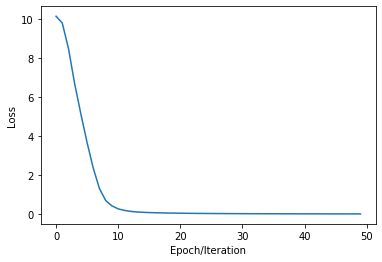

In [17]:
g1.train()

#### Generating Text

In [18]:
g1.generate_text(predict_len = 100)

'they yield but superfluity while were wholesome might guess relieved humanely think too dear leanness that afflicts object of misery as an inventory particularise their abundance sufferance gain them revenge this with pikes ere become rakes for gods i in hunger bread not thirst especially against he s very dog commonalty consider services has his country well could content give report fort pays himself being proud nay maliciously say unto hath famously did end though softconscienced men can was please mother partly which even till altitude virtue help nature account vice must way covetous need barren accusations faults surplus tire'

In [19]:
g1.generate_text(predict_len = 1000)

'they yield but superfluity while were wholesome might guess relieved humanely think too dear leanness that afflicts object of misery as an inventory particularise their abundance sufferance gain them revenge this with pikes ere become rakes for gods i in hunger bread not thirst especially against he s very dog commonalty consider services has his country well could content give report fort pays himself being proud nay maliciously say unto hath famously did end though softconscienced men can was please mother partly which even till altitude virtue help nature account vice must way covetous need barren accusations faults surplus tire repetition shouts these other side city risen why stay prating here capitol come soft who comes worthy menenius agrippa always loved honest enough rest so work my countrymen hand where go bats clubs matter pray business unknown senate had inkling fortnight intend do now show em deeds suitors strong breaths shall arms masters friends mine neighbours will und